# Demonstrate RL-Glue: Gridworld Cliff Walking Example

### Scott O’Hara - Metrowest Developers Machine Learning Group - 7/19/2020

Demonstrate RL-Glue using two RL algorithms in the context of a Gridworld Cliff Walking example:
- Sarsa with $\epsilon$-greedy action selection
- Q-Learning with $\epsilon$-greedy action selection

### Reference:
This notebook is adapted from three assignments in the Coursera course: ***Sample-based Learning Methods*** (M. White and A. White), University of Alberta, Alberta Machine Intelligence Institute.

https://www.coursera.org/learn/sample-based-learning-methods/

## Packages

1. ***numpy***: the fundamental package for scientific computing with Python.

2. ***scipy***: a Python library for scientific and technical computing.

3. ***matplotlib***: library for plotting graphs in Python.

4. ***RL-Glue***: library for reinforcement learning experiments.

5. ***tqdm.tqdm***: Provides progress bars for visualizing the status of loops.

6. ***pickle***: Save/retrieve serializable Python objects.

In [1]:
%matplotlib inline
import numpy as np
from scipy.stats import sem
import matplotlib.pyplot as plt
from rl_glue import RLGlue
import agent
import cliffworld_env
from tqdm import tqdm
import pickle

In [2]:
plt.rcParams.update({'font.size': 15})
plt.rcParams.update({'figure.figsize': [10,5]})

## Sarsa

Sarsa agent with $\epsilon$-greedy action selection (Section 6.4 in the textbook).

NOTE: SarsaAgent and QLearningAgent are identical except for the update rule in the agent_step() method.

In [3]:
class SarsaAgent(agent.BaseAgent):
    
    def agent_init(self, agent_init_info):
        """Setup for the agent called when the experiment first starts.
        
        Args:
        agent_init_info (dict), the parameters used to initialize the agent. The dictionary contains:
        {
            num_states (int): The number of states,
            num_actions (int): The number of actions,
            epsilon (float): The epsilon parameter for exploration,
            step_size (float): The step-size,
            discount (float): The discount factor,
        }
        
        """
        # Store the parameters provided in agent_init_info.
        self.num_actions = agent_init_info["num_actions"]
        self.num_states = agent_init_info["num_states"]
        self.epsilon = agent_init_info["epsilon"]
        self.step_size = agent_init_info["step_size"]
        self.discount = agent_init_info["discount"]
        self.rand_generator = np.random.RandomState(agent_info["seed"])
        
        # Create an array for action-value estimates and initialize it to zero.
        self.q = np.zeros((self.num_states, self.num_actions)) # The array of action-value estimates.

        
    def agent_start(self, state):
        """The first method called when the episode starts, called after
        the environment starts.
        Args:
            state (int): the state from the
                environment's evn_start function.
        Returns:
            action (int): the first action the agent takes.
        """
        
        # Choose action using epsilon greedy.
        current_q = self.q[state,:]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        self.prev_state = state
        self.prev_action = action
        return action
    
    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (int): the state from the
                environment's step based on where the agent ended up after the
                last step.
        Returns:
            action (int): the action the agent is taking.
        """
        
        # Choose action using epsilon greedy.
        current_q = self.q[state, :]
        if self.rand_generator.rand() < self.epsilon:
            next_action = self.rand_generator.randint(self.num_actions)
        else:
            next_action = self.argmax(current_q)
        
        # Perform an update
        self.q[self.prev_state, self.prev_action] +=\
            self.step_size*(reward + self.discount*current_q[next_action]\
                - self.q[self.prev_state, self.prev_action])
        
        self.prev_state = state
        self.prev_action = next_action
        return next_action
    
    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        # Perform the last update in the episode
        self.q[self.prev_state, self.prev_action] +=\
            self.step_size*(reward - self.q[self.prev_state, self.prev_action])
        
    def argmax(self, q_values):
        """argmax with random tie-breaking
        Args:
            q_values (Numpy array): the array of action-values
        Returns:
            action (int): an action with the highest value
        """
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)

## Q-Learning

Q-Learning agent with $\epsilon$-greedy action selection (Section 6.5 in the textbook). 

In [4]:
class QLearningAgent(agent.BaseAgent):
    def agent_init(self, agent_init_info):
        """Setup for the agent called when the experiment first starts.
        
        Args:
        agent_init_info (dict), the parameters used to initialize the agent. The dictionary contains:
        {
            num_states (int): The number of states,
            num_actions (int): The number of actions,
            epsilon (float): The epsilon parameter for exploration,
            step_size (float): The step-size,
            discount (float): The discount factor,
        }
        
        """
        # Store the parameters provided in agent_init_info.
        self.num_actions = agent_init_info["num_actions"]
        self.num_states = agent_init_info["num_states"]
        self.epsilon = agent_init_info["epsilon"]
        self.step_size = agent_init_info["step_size"]
        self.discount = agent_init_info["discount"]
        self.rand_generator = np.random.RandomState(agent_info["seed"])
        
        # Create an array for action-value estimates and initialize it to zero.
        self.q = np.zeros((self.num_states, self.num_actions)) # The array of action-value estimates.

        
    def agent_start(self, state):
        """The first method called when the episode starts, called after
        the environment starts.
        Args:
            state (int): the state from the
                environment's evn_start function.
        Returns:
            action (int): the first action the agent takes.
        """
        
        # Choose action using epsilon greedy.
        current_q = self.q[state,:]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        self.prev_state = state
        self.prev_action = action
        return action
    
    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (int): the state from the
                environment's step based on where the agent ended up after the
                last step.
        Returns:
            action (int): the action the agent is taking.
        """
        
        # Choose action using epsilon greedy.
        current_q = self.q[state, :]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        
        # Perform an update
        self.q[self.prev_state, self.prev_action] +=\
            self.step_size*(reward + self.discount*max(current_q) - self.q[self.prev_state, self.prev_action])
        
        self.prev_state = state
        self.prev_action = action
        return action
    
    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        # Perform the last update in the episode
        self.q[self.prev_state, self.prev_action] +=\
            self.step_size*(reward - self.q[self.prev_state, self.prev_action])
        
    def argmax(self, q_values):
        """argmax with random tie-breaking
        Args:
            q_values (Numpy array): the array of action-values
        Returns:
            action (int): an action with the highest value
        """
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)

## Section 3:  Solving the Cliff World

## The Cliff Walking Environment

The Cliff Walking environment is a gridworld with a discrete state space and discrete action space. The agent starts at grid cell S. The agent can move (deterministically) to the four neighboring cells by taking actions Up, Down, Left or Right. Trying to move out of the boundary results in staying in the same location. So, for example, trying to move left when at a cell on the leftmost column results in no movement at all and the agent remains in the same location. The agent receives -1 reward per step in most states, and -100 reward when falling off of the cliff. This is an episodic task. Termination occurs when the agent reaches the goal grid cell G. Falling off of the cliff results in resetting to the start state, without termination. Since episodes are undiscounted, we set $\gamma$=1.

The diagram below illustrates the two policies we are be evaluating.

<img src="cliffwalk.png" style="height:400px">

The following diagram illustrates some of the details of CliffWorld coordinate system.

<img src="cliffwalk-annotated.png" style="height:400px">

Using the experiment program in the cell below we now compare the agents on the Cliff World environment and plot the sum of rewards during each episode for the two agents.

The result of this cell will be graded. If you make any changes to your algorithms, you have to run this cell again before submitting the assignment.

100%|██████████| 100/100 [02:13<00:00,  1.34s/it]


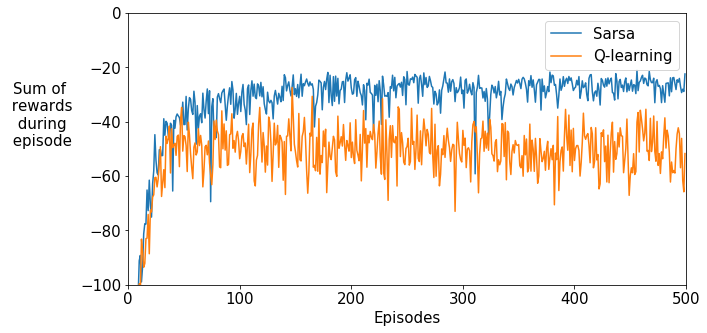

In [5]:
# Do not modify this cell!

agents = {
    "Sarsa": SarsaAgent,
    "Q-learning": QLearningAgent,
}
env = cliffworld_env.Environment
all_reward_sums = {} # Contains sum of rewards during episode
all_state_visits = {} # Contains state visit counts during the last 10 episodes
agent_info = {"num_actions": 4, "num_states": 48, "epsilon": 0.1, "step_size": 0.5, "discount": 1.0}
env_info = {}
num_runs = 100 # The number of runs
num_episodes = 500 # The number of episodes in each run

for algorithm in ["Sarsa", "Q-learning"]:
#for algorithm in ["Q-learning", "Expected Sarsa"]:
    all_reward_sums[algorithm] = []
    all_state_visits[algorithm] = []
    for run in tqdm(range(num_runs)):
        agent_info["seed"] = run
        rl_glue = RLGlue(env, agents[algorithm])
        rl_glue.rl_init(agent_info, env_info)

        reward_sums = []
        state_visits = np.zeros(48)
        for episode in range(num_episodes):
            if episode < num_episodes - 10:
                # Runs an episode
                rl_glue.rl_episode(0) 
            else: 
                # Runs an episode while keeping track of visited states
                state, action = rl_glue.rl_start()
                state_visits[state] += 1
                is_terminal = False
                while not is_terminal:
                    reward, state, action, is_terminal = rl_glue.rl_step()
                    state_visits[state] += 1             
            reward_sums.append(rl_glue.rl_return())
            
        all_reward_sums[algorithm].append(reward_sums)
        all_state_visits[algorithm].append(state_visits)

# save results
import os
import shutil
os.makedirs('results', exist_ok=True)
np.save('results/sarsa.npy', all_reward_sums['Sarsa'])
np.save('results/q_learning.npy', all_reward_sums['Q-learning'])
shutil.make_archive('results', 'zip', '.', 'results')

        
for algorithm in ["Sarsa", "Q-learning"]:
    plt.plot(np.mean(all_reward_sums[algorithm], axis=0), label=algorithm)
plt.xlabel("Episodes")
plt.ylabel("Sum of\n rewards\n during\n episode",rotation=0, labelpad=40)
plt.xlim(0,500)
plt.ylim(-100,0)
plt.legend()
plt.show()

To see why these two agents behave differently, let's inspect the states they visit most. Run the cell below to generate plots showing the number of timesteps that the agents spent in each state over the last 10 episodes.

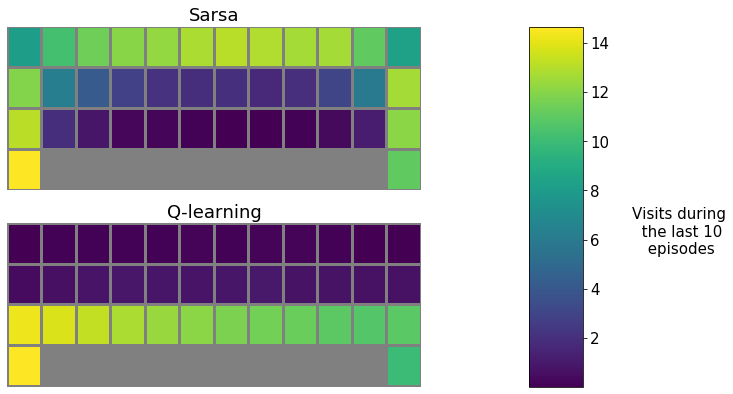

In [6]:
for algorithm, position in [("Sarsa", 211), ("Q-learning", 212)]:
    plt.subplot(position)
    average_state_visits = np.array(all_state_visits[algorithm]).mean(axis=0)
    grid_state_visits = average_state_visits.reshape((4,12))
    grid_state_visits[0,1:-1] = np.nan
    plt.pcolormesh(grid_state_visits, edgecolors='gray', linewidth=2)
    plt.title(algorithm)
    plt.axis('off')
    cm = plt.get_cmap()
    cm.set_bad('gray')

    plt.subplots_adjust(bottom=0.0, right=0.7, top=1.0)
    cax = plt.axes([0.85, 0.0, 0.075, 1.])
cbar = plt.colorbar(cax=cax)
cbar.ax.set_ylabel("Visits during\n the last 10\n episodes", rotation=0, labelpad=70)
plt.show()

The Q-learning agent learns the optimal policy, one that moves along the cliff and reaches the goal in as few steps as possible. However, since the agent does not follow the optimal policy and uses $\epsilon$-greedy exploration, it occasionally falls off the cliff. The Sarsa agent takes exploration into account and follows a safer path.

Previously we used a fixed step-size of 0.5 for the agents. What happens with other step-sizes? Does this difference in performance persist?

In the next experiment we will try 10 different step-sizes from 0.1 to 1.0 and compare the sum of rewards per episode averaged over the first 100 episodes (similar to the interim performance curves in Figure 6.3 of the textbook). Shaded regions show standard errors.

This cell takes around 10 minutes to run. The result of this cell will be graded. If you make any changes to your algorithms, you have to run this cell again before submitting the assignment.

100%|██████████| 100/100 [00:49<00:00,  2.01it/s]


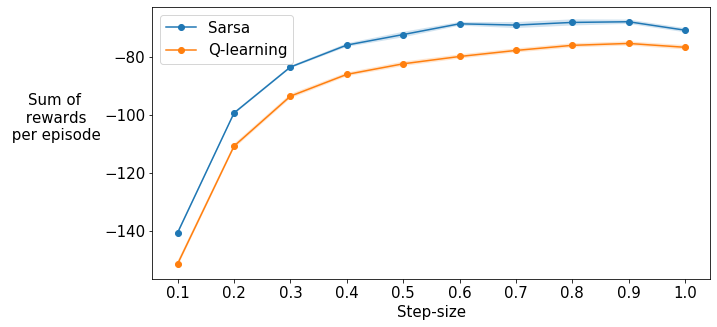

In [7]:
# Do not modify this cell!

agents = {
    "Sarsa": SarsaAgent,
    "Q-learning": QLearningAgent,
}
env = cliffworld_env.Environment
all_reward_sums = {}
step_sizes = np.linspace(0.1,1.0,10)
agent_info = {"num_actions": 4, "num_states": 48, "epsilon": 0.1, "discount": 1.0}
env_info = {}
num_runs = 100
num_episodes = 100
all_reward_sums = {}

for algorithm in ["Sarsa", "Q-learning"]:
    for step_size in step_sizes:
        all_reward_sums[(algorithm, step_size)] = []
        agent_info["step_size"] = step_size
        for run in tqdm(range(num_runs)):
            agent_info["seed"] = run
            rl_glue = RLGlue(env, agents[algorithm])
            rl_glue.rl_init(agent_info, env_info)

            return_sum = 0
            for episode in range(num_episodes):
                rl_glue.rl_episode(0)
                return_sum += rl_glue.rl_return()
            all_reward_sums[(algorithm, step_size)].append(return_sum/num_episodes)
        

for algorithm in ["Sarsa", "Q-learning"]:
    algorithm_means = np.array([np.mean(all_reward_sums[(algorithm, step_size)]) for step_size in step_sizes])
    algorithm_stds = np.array([sem(all_reward_sums[(algorithm, step_size)]) for step_size in step_sizes])
    plt.plot(step_sizes, algorithm_means, marker='o', linestyle='solid', label=algorithm)
    plt.fill_between(step_sizes, algorithm_means + algorithm_stds, algorithm_means - algorithm_stds, alpha=0.2)

plt.legend()
plt.xlabel("Step-size")
plt.ylabel("Sum of\n rewards\n per episode",rotation=0, labelpad=50)
plt.xticks(step_sizes)
plt.show()